# IMO zadanie 6 - Testy globalnej wypukłości

Emilia Maciejewska 136764 <br />

In [2]:
import tsplib95
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import datetime

# 0. Wczytywanie danych

In [3]:
problemA = tsplib95.load("kroA200.tsp")
problemA = problemA.as_keyword_dict()

In [4]:
problemB = tsplib95.load("kroB200.tsp")
problemB = problemB.as_keyword_dict()

In [5]:
def create_distance_matrix(data):
    dict_length = len(data['NODE_COORD_SECTION'])
    distance_matrix = np.zeros((dict_length, dict_length), dtype=int)
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix[i])):
            x1 = data['NODE_COORD_SECTION'][i+1]
            x2 = data['NODE_COORD_SECTION'][j+1]
            d = math.floor(math.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) + 0.5)
            distance_matrix[i][j] = d
    return distance_matrix

In [6]:
distance_matrix_A = create_distance_matrix(problemA)
distance_matrix_B = create_distance_matrix(problemB)

# 1.Algorytm losowy jako algorytm startowy

In [7]:
def selectStartingPoints(id):
    if id == 'A':
        max_id = max_id = len(distance_matrix_A) - 1 
    else:
        max_id = max_id = len(distance_matrix_B) - 1 
    p1 = random.randint(0, max_id)
    p2 = random.randint(0, max_id)
    while p2 == p1:
        p2 = random.randint(0, max_id)
    return p1, p2

In [8]:
def selectP(experimentId):
    p1 = 0
    p2 = 0
    while True:
        p1, p2 = selectStartingPoints(experimentId)
        sId1 = str(p1)+","+str(p2)
        sId2 = str(p2)+","+str(p1)
        if sId1 not in startingPoints and sId2 not in startingPoints:
            startingPoints[sId1] = 1
            break
    return p1, p2

In [9]:
def random_start(experimentId, p1, p2):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    matrix_length = len(mat) 
    d_matrix = []

    result = [[],[]]
    resultVal = [[0],[0]]
    cycleId = 0
    for point in sorted(list(range(matrix_length)), key=lambda x:random.random()):
        result[cycleId].append(point)
        if len(result[cycleId]) > 1:
            resultVal[cycleId] += mat[result[cycleId][-2]][result[cycleId][-1]]
        cycleId = 0 if cycleId else 1
        
    resultVal[0] += mat[result[0][-1]][result[0][0]]
    resultVal[1] += mat[result[1][-1]][result[1][0]]
    result[0].append(result[0][0])
    result[1].append(result[1][0]) 
    return result, resultVal

# 2. Lokalne przeszukiwanie metoda greedy

## 3.1 Sąsiedztwo międzytrasowe wierzchołki

In [10]:
def externalVertexGreedy (mat, aA, aB, cR, vR, dR):   
    r = []
    delta = np.inf
    aA = np.copy(aA)
    aB = np.copy(aB)
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    if dR == 0:
        for i in range(vR, len(aA)-1):
            for j in range(vR, len(aB)-1):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
        for i in range(1, vR):
            for j in range(1, vR):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
    else:
        for i in range(len(aA)-2, vR+1, -1):
            for j in range(len(aB)-2, vR+1, -1):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
        for i in range(vR-1, 0, -1):
            for j in range(vR-1, 0, -1):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
    return delta, r, False

## 3.2 Sąsiedztwo wewnątrztrasowe wierzchołki

In [11]:
def internalVertexSingle (mat, aA, aB, vR): 
    d = np.inf
    r = []
    for i in range(vR, len(aA)-1):
        for j in range(i+1,  len(aA)-1):
            dis1 = 0
            dis2 = 0
            if i+1 != j and (i!=1 or j!=50):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]] + mat[aA[j-1]][aA[j]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[j]][aA[i+1]] + mat[aA[j-1]][aA[i]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True
    for i in range(1, vR):
        for j in range(i+1,  vR):
            dis1 = 0
            dis2 = 0
            if i+1 != j and (i!=1 or j!=50):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]] + mat[aA[j-1]][aA[j]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[j]][aA[i+1]] + mat[aA[j-1]][aA[i]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True 
                        
    for i in range(1, len(aB)-1):
        for j in range(i+1,  len(aB)-1):
            dis1 = 0
            dis2 = 0
            if i+1 != j and (i!=1 or j!=50):
                dis1 = mat[aB[i-1]][aB[i]] + mat[aB[i]][aB[i+1]] + mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[i-1]][aB[j]] + mat[aB[j]][aB[i+1]] + mat[aB[j-1]][aB[i]] + mat[aB[i]][aB[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aB[i], aB[j]]
                    return d, r, True
    return d, r, False

In [12]:
def internalVertexGreedy (mat, aA, aB, cR, vR, dR):
    r = []
    delta = np.inf
    aA = np.copy(aA)
    aB = np.copy(aB)
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    
    if cR == 0:  
        d, r, success = internalVertexSingle (mat, aA, aB, vR)
    elif cR == 1:
        d, r, success = internalVertexSingle (mat, aB, aA, vR)
    return d, r, success


## 3.3 Sąsiedztwo wewnątrztrasowe krawędzie

In [13]:
def internalEdgesSingle (mat, aA, aB, vR):
    d = np.inf
    r = []
    for i in range(vR, len(aA)):
        for j in range(i+1,  len(aA)-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True
    for i in range(1, vR):
        for j in range(i+1,  vR-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True
    for i in range(1, len(aB)):
        for j in range(i+1,  len(aB)-1):
            if i+1 != j:
                dis1 = mat[aB[i-1]][aB[i]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[i-1]][aB[j]] + mat[aB[i]][aB[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aB[i], aB[j]]
                    return d, r, True
    return d, r, False

In [14]:
def internalEdgesGreedy (mat, aA, aB, cR, vR, dR):
    r = []
    delta = np.inf 
    
    if cR == 0:  
        d, r, success = internalEdgesSingle (mat, aA, aB, vR)
    elif cR == 1:
        d, r, success = internalEdgesSingle (mat, aB, aA, vR)

    return d, r, success


## 3.4 Wybór sąsiedztwa

In [15]:
def neighborGreedy(experimentId, result, typeG):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    algoType = random.randint(0, 1) # typ sąsiedztwa sprawdzany na początku
    cycleRandom = random.randint(0, 1) # wybór cyklu od któego zaczynamy
    vertexRandom = random.randint(1, len(mat)/2-1) # wybór pozycji w cyklu, od której zaczynamy
    directionRandom = random.randint(0, 1) # wybór kierunku przeglądania
    
    if typeG == 0:
        if algoType == 0:
            delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 0, True
            else:
                delta, r, success = internalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 1, success
        else:
            delta, r, success = internalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 1, True
            else:
                delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 0, success 
    else: 
        if algoType == 0:
            delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 0, True
            else:
                delta, r, success = internalEdgesGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 2, success
        else:
            delta, r, success = internalEdgesGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 2, True
            else:
                delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 0, success

## 3.5 Obliczanie funkcji celu

In [16]:
def greedyV (experimentId, result, resultVal, typeG):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1, typeA, success = neighborGreedy(experimentId, result, typeG)
        if (success == False):
            return result, resultVal
        
        if typeA == 0: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        elif typeA == 1:
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        elif typeA == 2:
            if r1[0] in result[0]:
                cycleId = 0
            else:
                cycleId = 1
            r = r1
            tempA = []
            index1 = np.where(result[cycleId] == r[0])
            index2 = np.where(result[cycleId] == r[1])
            tempA = np.copy(result[cycleId])
            tempA = tempA[index1[0][0]+1: index2[0][0]]
            
            if cycleId == 1:
                newResultVal[0] = np.copy(resultVal[0])
                newResult[0] = np.copy(result[0])
            else:
                newResultVal[1] = np.copy(resultVal[1])
                newResult[1] = np.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[1])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(r[0])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]
            
        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        
    return result, resultVal

# 4. Eksperyment obliczeniowy

In [17]:
resultGA = []
resultValGA = []
resultGB = []
resultValGB = []

In [18]:
def runExperimentA(experimentId):
    itersNumber = 1000
    
    for i in range(itersNumber):
        p1, p2 = selectP(experimentId)
     
        #seed losowy
        start, startVal = random_start(experimentId, p1, p2)

        #wierzchołki, krawędzie
        r, v = greedyV(experimentId, start, startVal, 1)
        resultGA.append(r)
        resultValGA.append(v)

In [19]:
def runExperimentB(experimentId):
    itersNumber = 1000
    
    for i in range(itersNumber):
        print(i)
        p1, p2 = selectP(experimentId)
     
        #seed losowy
        start, startVal = random_start(experimentId, p1, p2)

        #wierzchołki, krawędzie
        r, v = greedyV(experimentId, start, startVal, 1)
        resultGB.append(r)
        resultValGB.append(v)

In [20]:
startingPoints = dict()
runExperimentA('A')

In [21]:
startingPoints = dict()
runExperimentB('B')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# 5. Wyniki

In [22]:
problemA['NODE_COORD_SECTION']
dataA = []
for i in range(1, len(problemA['NODE_COORD_SECTION'])+1):
    dataA.append(problemA['NODE_COORD_SECTION'][i])
dataArrA = np.array(dataA)

In [23]:
problemB['NODE_COORD_SECTION']
dataB = []
for i in range(1, len(problemB['NODE_COORD_SECTION'])+1):
    dataB.append(problemB['NODE_COORD_SECTION'][i])
dataArrB = np.array(dataB)

In [24]:
def print_plot(data, points, title, fileName):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points[0], 0], data[points[0], 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points[0], 0], data[points[0], 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.plot(data[points[1], 0], data[points[1], 1], "o", color='tab:red',  linewidth=0, alpha=0.6)
    plt.plot(data[points[1], 0], data[points[1], 1], "--", color="tab:orange", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(fileName, bbox_inches='tight')

In [25]:
def summarize(result, resultVal, title, dataArr):
    valueArray = np.sum(resultVal, axis=1)
    print("wyniki algorytmu")
    print("min:", np.min(valueArray))
    print("max:", np.max(valueArray))
    print("mean:", np.mean(valueArray))
    index = np.argmin(valueArray)
    print_plot(dataArr, result[index], title, title + ".png")
    plt.show()

wyniki algorytmu
min: 36153
max: 44974
mean: 39950.492


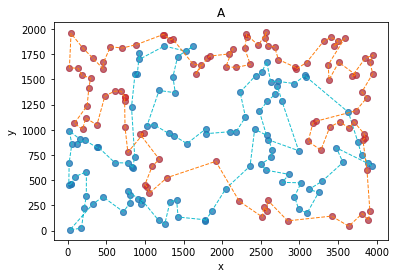

wyniki algorytmu
min: 36732
max: 43771
mean: 40027.5


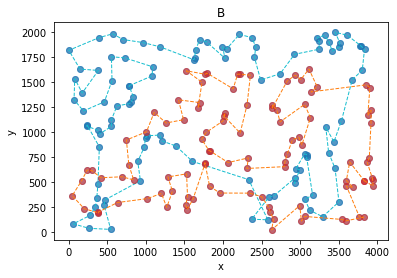

In [26]:
summarize(resultGA, resultValGA, "A", dataArrA)
summarize(resultGB, resultValGB, "B", dataArrB)

# 6.Obliczanie prawdopodobieństwa

**Najlepsze rozwiązanie**

In [52]:
valueArrayA = np.sum(resultValGA, axis=1)
best_indexA = np.argmin(valueArrayA)
best_resultA = resultGA[best_indexA]
print(valueArrayA[best_indexA])
print(best_resultA)

36153
[[ 10  83  47 165  95 125  86 164 103  96  80  44 196  32 155  99 179 130
  141  68 188   2  72  58  40  29 160 124 150 186   5 108  53 167 180   1
   34  67 168 172  22 149 143  69  75  93  90  94  85 138 104  42   4 195
   38 133  21  74 106 156 119  46  30  64  79  76 157 127 192  59 100   3
  162  92  11 146  39 131 144  84 110 120 173  45 171  48  98 174   9  91
  118  65 152  43 115 187 193 121 169  51  10]
 [109  28 183  36 178  15  62  50 117 123 137   8  77  81   6 198  25  60
  135  31  23 158 116 114  52   0 190 197  26 122  14  78 159  12 176  66
  161  63  19  54 134  41 185 126 111 154 182   7  16  24  89 142  33 145
  128 102  97 113  57 140 170 199  87 147  27  82  61 184  49  71 129  70
   37  55 151 177 136 132 175 112 194 181 101 163  20 139 153  88 166 107
   73  56  35  13 191 148 105  18 189  17 109]]


In [28]:
valueArrayB = np.sum(resultValGB, axis=1)
best_indexB = np.argmin(valueArrayB)
best_resultB = resultGB[best_indexB]
print(valueArrayB[best_indexB])
print(best_resultB)

36732
[[ 63 181  82  32 146  81 109  62  30 194  47 120 155  50 127 111  14   5
    3 113 167 132  65 144 177 198 130 156 171  34  60  26  70 106  31 166
  174  58 135  28   7  98  75  96  90 128  27 157   2 141   9 122  67 110
  193  61  25 149  68  48  85 137 180 133  74  29 126 123  46 178 183 176
  163  49 158 139 182 102  76 152  95 136 134 129  43 199  91 118  35  77
  125 186  12 154   1 108  41 119 124  13  63]
 [ 38 197  69 148 169  52  72 121  84  92  10   0  94  97 173  11 160  24
    8  45 145  89  20 165 107 151  37  19  79  36  71 114  53 162 115  51
   57   6  83 168  33 175 179  93  56  73 164  86  59 195 185  88  42 184
  117 105  15 104  23  17  44  16 191  40 147 101  18 150 161 159 143 192
  103  54 142 170  21  22  87 190 153 138 172 140  64 187  78 112  80 100
   55  99 131   4  66 196 116  39 189 188  38]]


## Miary podobieństwa

**Wspólne wierzchołki**

In [48]:
def common_vertices(result1, result2):
    counter = 0
    for j in range(len(result1)):
        c1 = list(set(result1[j]).intersection(result2[0]))
        c2 = list(set(result1[j]).intersection(result2[1]))
        count = len(c1) if len(c1)>len(c2) else len(c2)
        counter += count
    return counter

**Wspólne krawędzie**

In [75]:
def common_edges(result1, result2):
    counter = 0
    for j in range(len(result1)):
        for k in range(0, len(result1[j])-1):
            indices = list(zip(*np.where(result2 == result1[j][k])))
            ids = indices[0]
            if result1[j][k+1] == result2[ids[0]][ids[1]+1]:
                counter += 1
    return counter      

**Wizualizacja**

In [101]:
def showSimilarity(res, v, title):
    f = plt.figure()
    plt.scatter(res, v)
    plt.xlabel("wartość f. celu", fontsize=14)
    plt.ylabel("podobieństwo", fontsize=14)
    plt.title(title, fontsize=16) 
    plt.gcf().set_dpi(100)
    plt.gcf().set_size_inches((12, 8))
    plt.show()
    f.savefig(title+'.png')

### Podobieństwo do najlepszego rozwiązania

**Instancja A**

In [86]:
countVerticesA = []
for i in range(len(resultGA)):
    c = common_vertices(resultGA[i], best_resultA)
    countVerticesA.append(c)
print(len(countVerticesA))   

1000


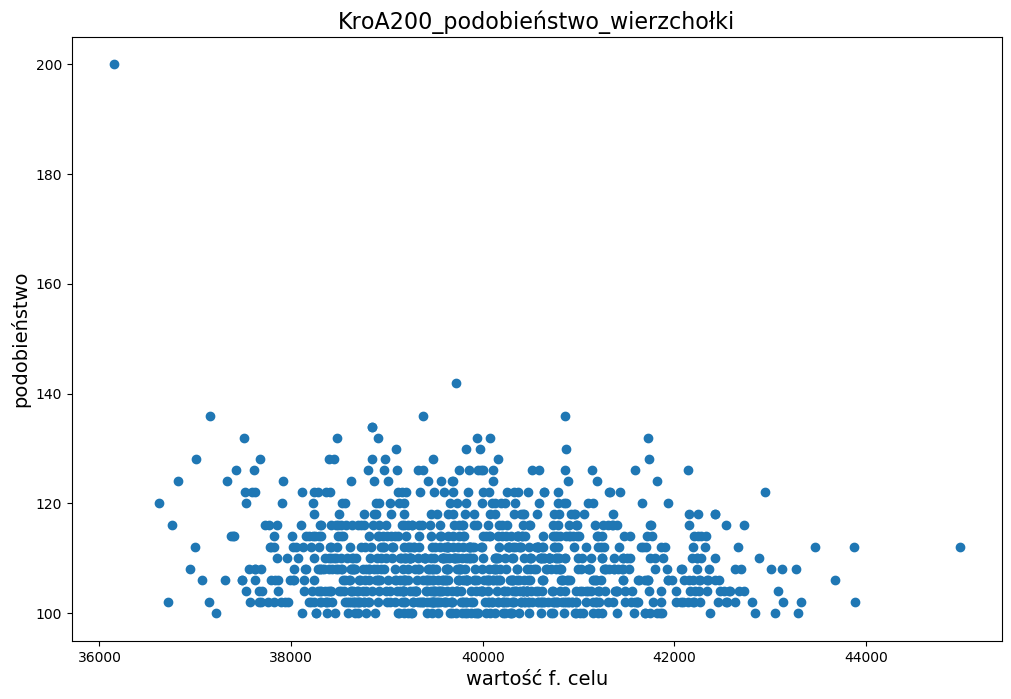

In [103]:
valueArrayA = np.sum(resultValGA, axis=1)
showSimilarity(valueArrayA, countVerticesA, "KroA200_podobieństwo_wierzchołki")

In [118]:
print(np.corrcoef(valueArrayA, countVerticesA))

[[ 1.         -0.12727547]
 [-0.12727547  1.        ]]


In [77]:
countEdgesA = []
for i in range(len(resultGA)):
    c = common_edges(resultGA[i], best_resultA)
    countEdgesA.append(c)
print(len(countEdgesA))

1000


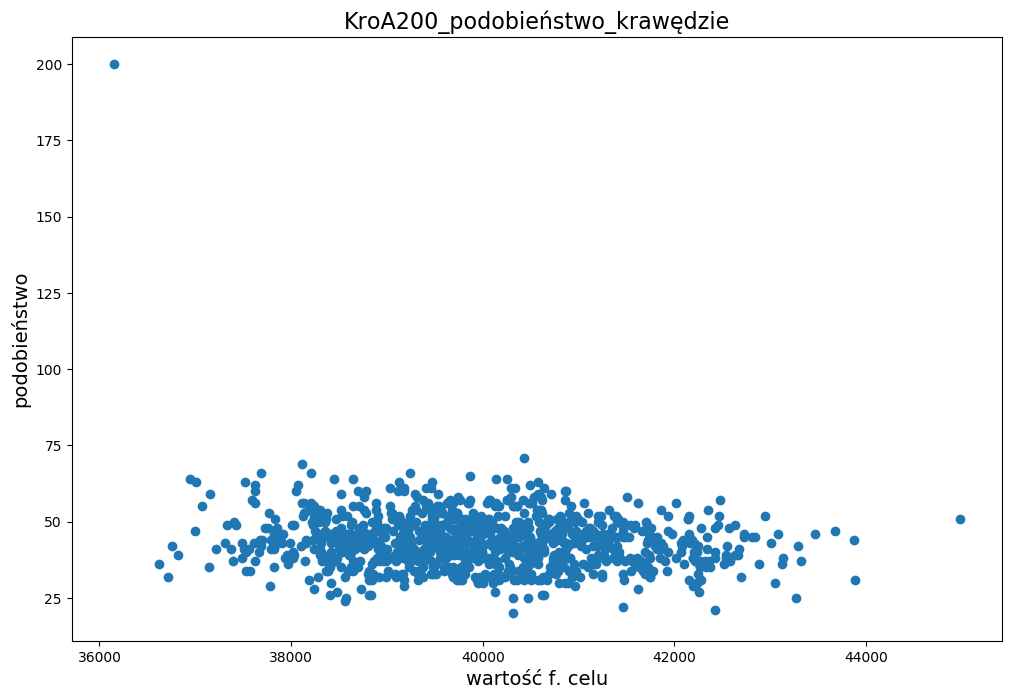

In [104]:
valueArrayA = np.sum(resultValGA, axis=1)
showSimilarity(valueArrayA, countEdgesA, "KroA200_podobieństwo_krawędzie")

In [119]:
print(np.corrcoef(valueArrayA, countEdgesA))

[[ 1.         -0.15241584]
 [-0.15241584  1.        ]]


**Instancja B**

In [56]:
countVerticesB = []
for i in range(len(resultGB)):
    c = common_vertices(resultGB[i], best_resultB)
    countVerticesB.append(c)
print(len(countVerticesB))

1000


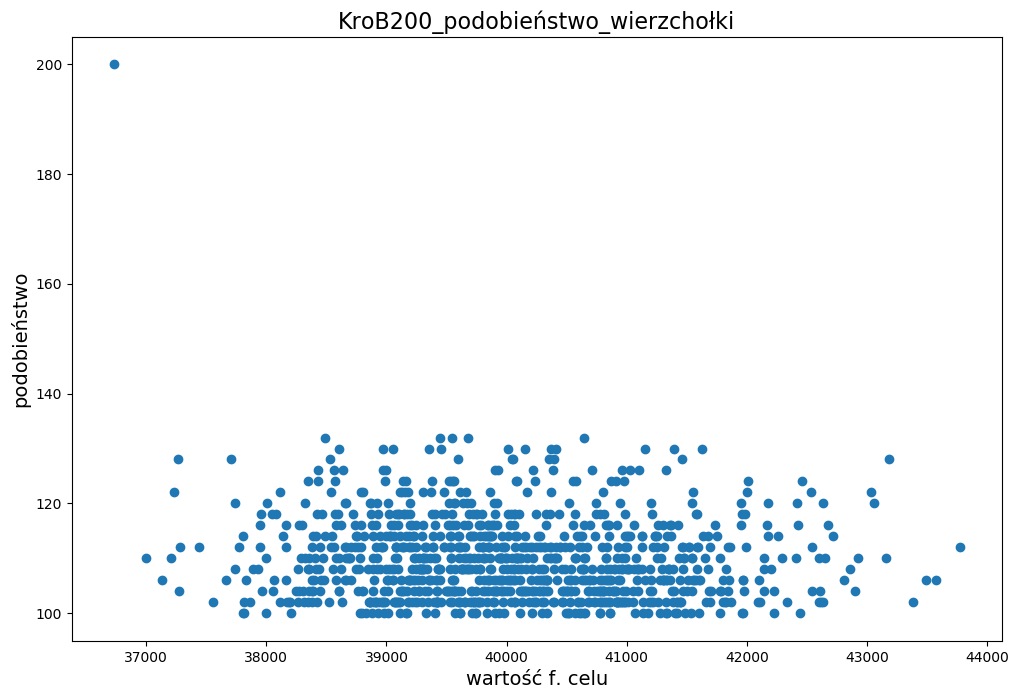

In [105]:
valueArrayB = np.sum(resultValGB, axis=1)
showSimilarity(valueArrayB, countVerticesB, "KroB200_podobieństwo_wierzchołki")

In [120]:
print(np.corrcoef(valueArrayB, countVerticesB))

[[ 1.        -0.1022972]
 [-0.1022972  1.       ]]


In [79]:
countEdgesB = []
for i in range(len(resultGB)):
    c = common_edges(resultGB[i], best_resultB)
    countEdgesB.append(c)
print(len(countEdgesB))

1000


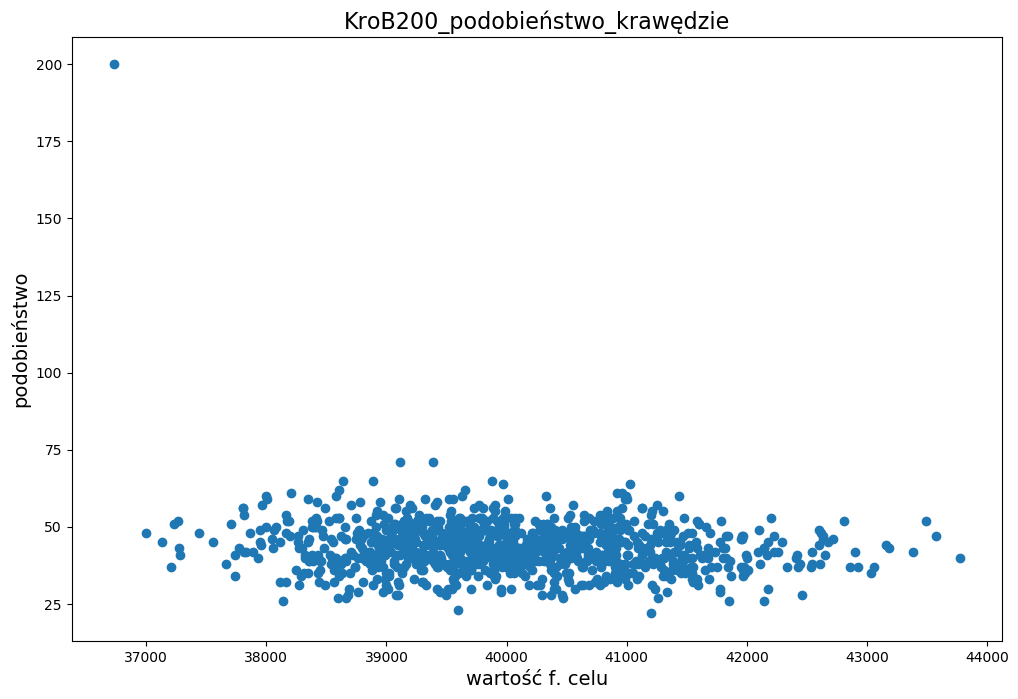

In [106]:
valueArrayB = np.sum(resultValGB, axis=1)
showSimilarity(valueArrayB, countEdgesB, "KroB200_podobieństwo_krawędzie")

In [121]:
print(np.corrcoef(valueArrayB, countEdgesB))

[[ 1.         -0.14839731]
 [-0.14839731  1.        ]]


### Średnie podobieństwo

**Instancja A**

In [110]:
countAvVerticesA = []
for i in range(len(resultGA)):
    sumRes = 0
    c = 0
    for z in range(len(resultGA)):
        if i != z:
            sumRes += common_vertices(resultGA[i], resultGA[z])
            c += 1
    countAvVerticesA.append(sumRes/c)
print(countAvVerticesA)
print(len(countAvVerticesA))

[108.32232232232232, 108.64064064064064, 107.85185185185185, 107.96596596596596, 108.65265265265265, 108.29629629629629, 108.64864864864865, 108.8048048048048, 108.76276276276276, 108.34634634634635, 108.73673673673673, 108.86886886886887, 108.002002002002, 108.93293293293293, 109.06906906906907, 108.5945945945946, 108.48248248248248, 108.3983983983984, 108.27627627627628, 108.55855855855856, 108.97097097097097, 109.09709709709709, 107.57557557557557, 108.13413413413413, 109.88188188188188, 109.54754754754755, 107.96996996996997, 108.54054054054055, 107.22722722722723, 108.45445445445445, 107.68568568568568, 108.37237237237237, 107.995995995996, 107.68568568568568, 108.4084084084084, 108.61261261261261, 107.95195195195195, 109.07507507507508, 108.74274274274275, 107.84584584584584, 108.93893893893893, 109.46746746746747, 107.36536536536536, 108.47847847847848, 108.75275275275276, 109.08108108108108, 107.71771771771772, 108.84884884884885, 108.90290290290291, 108.2002002002002, 108.4564

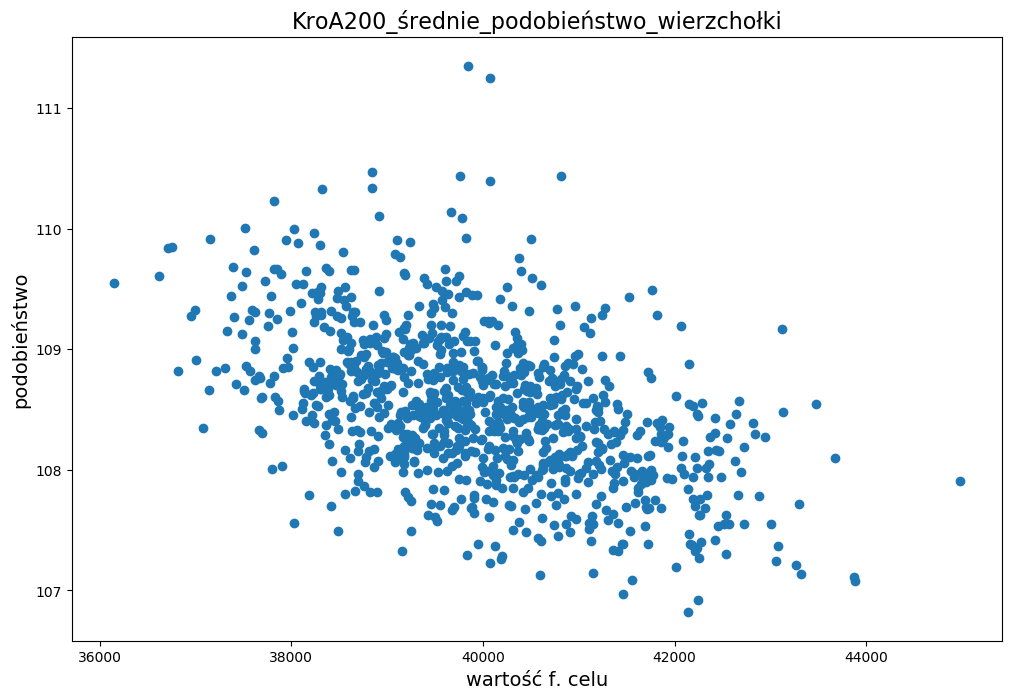

In [111]:
valueArrayA = np.sum(resultValGA, axis=1)
showSimilarity(valueArrayA, countAvVerticesA, "KroA200_średnie_podobieństwo_wierzchołki")

In [122]:
print(np.corrcoef(valueArrayA, countAvVerticesA))

[[ 1.         -0.49365846]
 [-0.49365846  1.        ]]


In [114]:
countAvEdgesA = []
for i in range(len(resultGA)):
    sumRes = 0
    c = 0
    for z in range(len(resultGA)):
        if i != z:
            sumRes += common_edges(resultGA[i], resultGA[z])
            c += 1
    countAvEdgesA.append(sumRes/c)
print(countAvEdgesA)
print(len(countAvEdgesA))

[38.908908908908906, 41.54354354354354, 37.931931931931935, 40.74174174174174, 40.65765765765766, 40.087087087087085, 40.349349349349346, 39.51651651651652, 39.191191191191194, 41.15615615615616, 41.6026026026026, 41.13813813813814, 40.75675675675676, 41.052052052052055, 39.307307307307305, 41.946946946946944, 38.049049049049046, 39.726726726726724, 41.21521521521522, 41.054054054054056, 39.371371371371374, 40.249249249249246, 41.871871871871875, 40.13813813813814, 43.593593593593596, 43.55755755755756, 38.566566566566564, 39.14014014014014, 38.972972972972975, 40.987987987987985, 37.946946946946944, 41.449449449449446, 39.3043043043043, 39.8998998998999, 41.788788788788786, 40.36536536536536, 39.32132132132132, 40.887887887887885, 41.772772772772775, 38.986986986986985, 40.5955955955956, 40.77677677677678, 39.01901901901902, 39.231231231231234, 39.24524524524524, 41.2962962962963, 38.7987987987988, 41.41641641641642, 39.87487487487488, 39.448448448448445, 40.42542542542542, 41.3053053

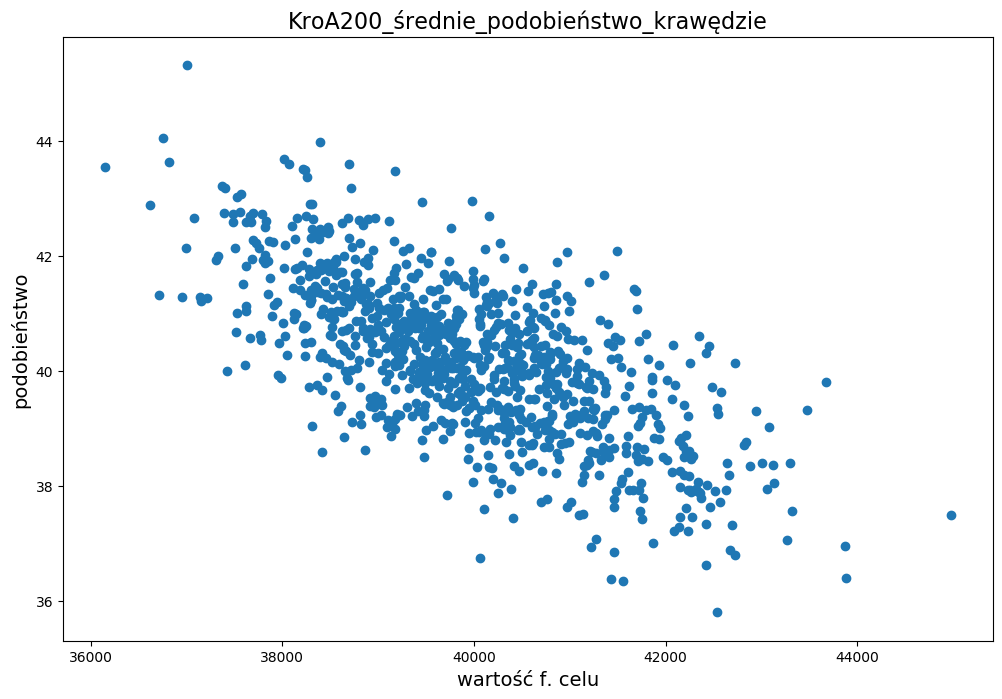

In [115]:
valueArrayA = np.sum(resultValGA, axis=1)
showSimilarity(valueArrayA, countAvEdgesA, "KroA200_średnie_podobieństwo_krawędzie")

In [123]:
print(np.corrcoef(valueArrayA, countAvEdgesA))

[[ 1.         -0.67932943]
 [-0.67932943  1.        ]]


**Instancja B**

In [112]:
countAvVerticesB = []
for i in range(len(resultGB)):
    sumRes = 0
    c = 0
    for z in range(len(resultGB)):
        if i != z:
            sumRes += common_vertices(resultGB[i], resultGB[z])
            c += 1
    countAvVerticesB.append(sumRes/c)
print(countAvVerticesB)
print(len(countAvVerticesB))

[107.48148148148148, 108.86686686686687, 108.6046046046046, 108.29229229229229, 108.34034034034035, 108.48448448448448, 107.66166166166167, 108.10810810810811, 108.09009009009009, 107.993993993994, 107.66166166166167, 107.87787787787788, 108.75275275275276, 108.89289289289289, 108.44244244244244, 108.52852852852853, 108.2102102102102, 107.69369369369369, 108.18218218218219, 108.26026026026027, 109.17317317317317, 108.87087087087087, 107.91391391391392, 108.5985985985986, 109.11111111111111, 109.14914914914915, 109.34934934934935, 108.67667667667668, 109.96596596596596, 109.72572572572572, 107.87787787787788, 107.98398398398399, 108.54254254254255, 107.997997997998, 108.1941941941942, 108.28428428428428, 108.57057057057057, 107.62362362362363, 107.62762762762763, 108.68668668668668, 108.71071071071071, 108.27627627627628, 108.02602602602603, 108.42042042042043, 109.95595595595596, 108.87087087087087, 107.995995995996, 108.46646646646647, 109.23523523523524, 107.38138138138139, 108.08808

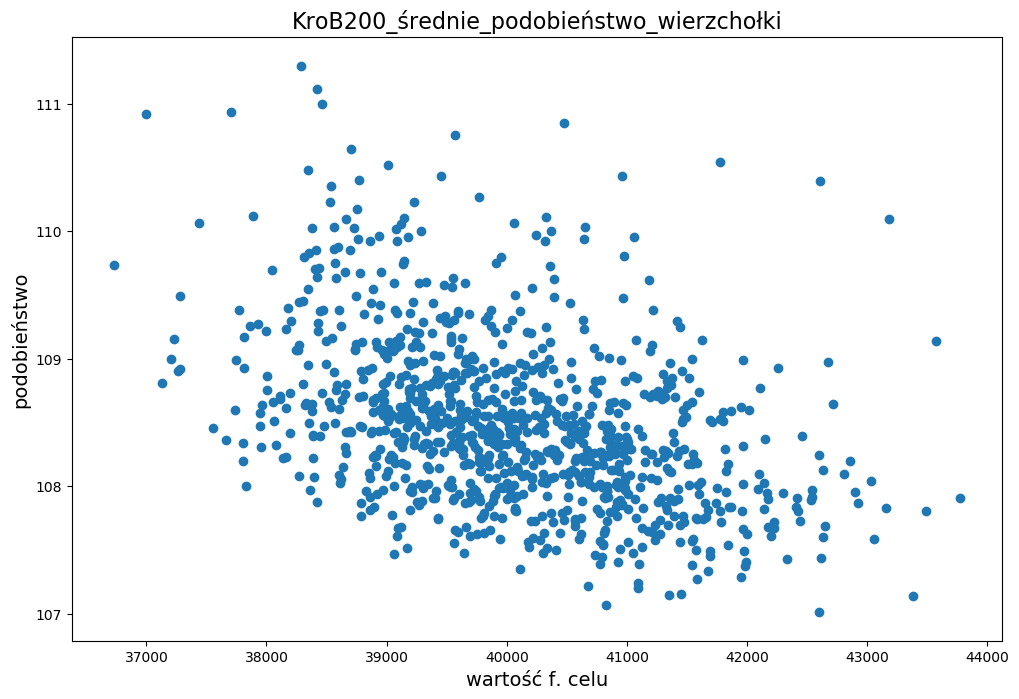

In [113]:
valueArrayB = np.sum(resultValGB, axis=1)
showSimilarity(valueArrayB, countAvVerticesB, "KroB200_średnie_podobieństwo_wierzchołki")

In [124]:
print(np.corrcoef(valueArrayB, countAvVerticesB))

[[ 1.         -0.41350205]
 [-0.41350205  1.        ]]


In [116]:
countAvEdgesB = []
for i in range(len(resultGB)):
    sumRes = 0
    c = 0
    for z in range(len(resultGB)):
        if i != z:
            sumRes += common_edges(resultGB[i], resultGB[z])
            c += 1
    countAvEdgesB.append(sumRes/c)
print(countAvEdgesB)
print(len(countAvEdgesB))

[39.72072072072072, 41.150150150150154, 40.585585585585584, 40.08008008008008, 39.985985985985984, 39.95695695695696, 39.47547547547548, 40.868868868868866, 39.62462462462462, 38.271271271271274, 39.8988988988989, 40.93793793793794, 41.968968968968966, 41.91591591591592, 39.92192192192192, 39.02502502502502, 39.987987987987985, 38.173173173173176, 41.627627627627625, 38.486486486486484, 41.432432432432435, 42.38038038038038, 41.828828828828826, 38.6046046046046, 41.42242242242242, 39.753753753753756, 41.21821821821822, 39.625625625625624, 39.230230230230234, 37.673673673673676, 39.628628628628626, 39.8048048048048, 38.51751751751752, 39.65465465465466, 39.548548548548546, 39.77877877877878, 39.1971971971972, 36.48248248248248, 38.633633633633636, 40.091091091091094, 40.128128128128125, 39.03603603603604, 36.748748748748746, 43.93793793793794, 40.23823823823824, 40.490490490490494, 40.04004004004004, 40.35535535535536, 39.166166166166164, 34.769769769769766, 39.81981981981982, 39.314314

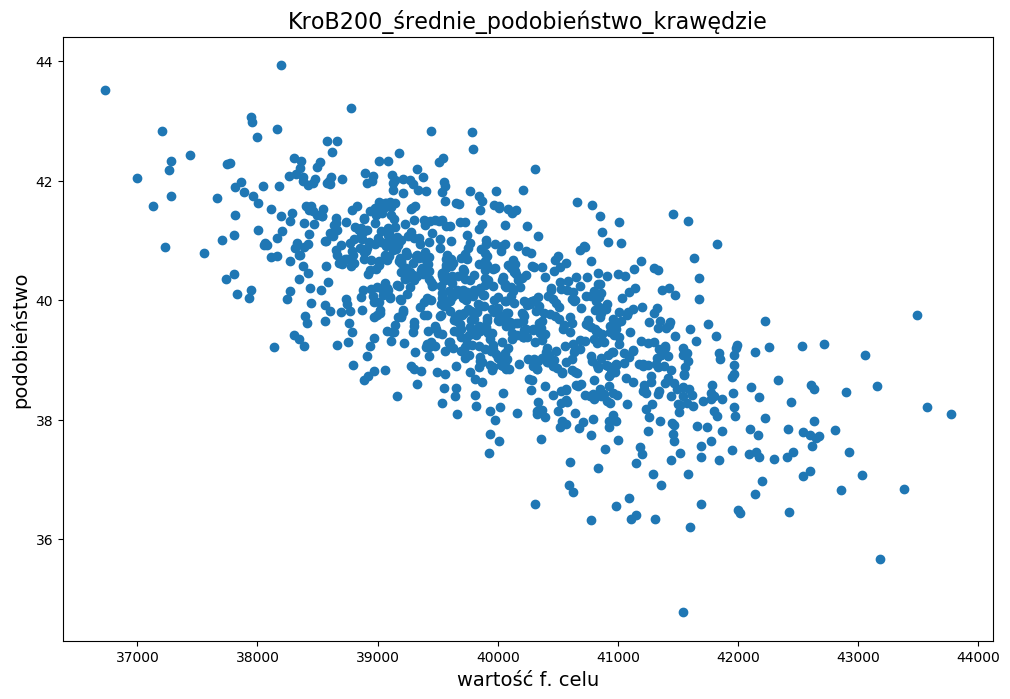

In [117]:
valueArrayB = np.sum(resultValGB, axis=1)
showSimilarity(valueArrayB, countAvEdgesB, "KroB200_średnie_podobieństwo_krawędzie")

In [125]:
print(np.corrcoef(valueArrayB, countAvEdgesB))

[[ 1.         -0.68455273]
 [-0.68455273  1.        ]]
